In [47]:
# %%

# Notebook: Tarea 1 - Punto 2
# Modelo de la cadena de Markov para "Serpientes y Escaleras" (casillas 1..50)

# Contenido:
# - Construcción de la matriz, cálculo de π por los tres métodos, simulaciones, gráficos (convergencia, histograma de duración, visitas por casilla)
# - Guardado de CSVs: matriz_transicion.csv, pi_vector.csv, pi_vector_simulation.csv, visitas_por_partida.csv
# - Impresiones de progreso durante las fases largas (construcción, iteraciones, simulaciones) para que veas cómo avanza.
# - Cálculo de duración esperada de partida (simulación) y vector de visitas por partida
# - Gráficas: convergencia π, histograma duración partidas, visitas por casilla

# Todas las librerías usadas son estándar (numpy, pandas, matplotlib).

In [48]:
# IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
from math import isclose

# Para reproducibilidad en simulaciones
RANDOM_SEED = 42

In [49]:
# PARÁMETROS Y MAPA DE SALTOS 
escaleras = {6:24, 19:30, 16:37, 13:43, 40:50}
serpientes = {18:10, 49:17, 36:15, 46:25, 41:22, 23:11}
saltos = {**escaleras, **serpientes}

N = 50  # casillas 1..50

# Convierte saltos a indices 0-based para uso interno
jump_idx = {k-1: v-1 for k,v in saltos.items()}

print("Saltos (0-based):", jump_idx)

Saltos (0-based): {5: 23, 18: 29, 15: 36, 12: 42, 39: 49, 17: 9, 48: 16, 35: 14, 45: 24, 40: 21, 22: 10}


In [50]:
# FUNCION: construir matriz de transición P (50x50)
# Reglas implementadas:
# - Dado justo 1..6
# - Si sale 6 y tras el movimiento no se activa escalera/serpiente, se repite el turno
# - Si sale 6 y tras movimiento activa escalera/serpiente, NO se repite
# - Si el dado hace que se pase (>50) no te mueves; si fue 6 y te pasas, repetís el turno
# - Saltos inmediatos: si la casilla final es base de escalera o cabeza de serpiente -> ir inmediatamente al destino
# - Al llegar exactamente a 50, la partida se reinicia a 1 (50->1) -> modelado como estado 50 con prob 1 a 1

def build_transition_matrix(verbose=True):
    P = np.zeros((N,N), dtype=float)
    if verbose:
        print("Construyendo matriz de transición (50x50)...")
    for i in range(N):
        if verbose and i % 10 == 0:
            print(f"  Procesando fila {i+1}/50...")
        # Si la casilla i es inicio de salto, el turno termina en la casilla destino inmediatamente
        if i in jump_idx:
            dest = jump_idx[i]
            # si destino es 49 (casilla 50), se reinicia -> estado 0
            P[i, 0 if dest == 49 else dest] = 1.0
            continue
        # si la casilla es la meta (49 index), modelamos reinicio 50->1
        if i == 49:
            P[i, 0] = 1.0
            continue

        # acumulador de probabilidades por resultado final del turno
        contrib = np.zeros(N, dtype=float)
        # probabilidad de que el turno continúe debido a un 6 que no activa salto ni meta
        prob_continue_same = 0.0
        # admin: si cae en 6 que mueve a pos y no salto, entonces contribution includes later extra-turn process
        # pero lo resolvemos con un término recursivo (ver más abajo)

        target6 = None

        # caras 1..5 (no repetición por 6)
        for d in range(1,6):
            if i + d > 49:
                # se pasa: no se mueve
                contrib[i] += 1/6
            else:
                newpos = i + d
                if newpos == 49:
                    # llega exactamente a 50 -> reinicia a 1
                    contrib[0] += 1/6
                elif newpos in jump_idx:
                    dest = jump_idx[newpos]
                    contrib[0 if dest == 49 else dest] += 1/6
                else:
                    contrib[newpos] += 1/6

        # cara 6
        if i + 6 > 49:
            # si rebasa con 6: se queda en i; pero si es 6, se repite el turno
            prob_continue_same = 1/6
        else:
            newpos = i + 6
            if newpos == 49:
                contrib[0] += 1/6
            elif newpos in jump_idx:
                dest = jump_idx[newpos]
                contrib[0 if dest == 49 else dest] += 1/6
                # si activa salto al caer con 6, NO repites turno -> no continuación
            else:
                # se va a newpos y se obtiene un extra-turn desde newpos
                target6 = newpos

        # Resolver efecto de repeticiones infinitas cuando hay chance de quedarse y repetir (prob_continue_same > 0)
        # Si hay prob_continue_same > 0, la fila resulta ser contrib/(1 - prob_continue_same)
        if prob_continue_same > 0:
            P[i, :] = contrib / (1 - prob_continue_same)
        else:
            if target6 is None:
                P[i, :] = contrib
            else:
                # la probabilidad de iniciar con 6 y luego terminar en j es (1/6) * P[target6, j]
                # entonces P[i] = contrib + (1/6) * P[target6]
                # pero P[target6] puede no estar construida aún (si target6 > i). Para evitar dependencia
                # ordenada, solucionamos con un sistema lineal por bloques o iterativo. Aquí usamos un
                # enfoque resolviendo las ecuaciones lineales globales: (I - A) P = B. Sin embargo para
                # simplicidad computacional, construimos líneas en orden decendente y en caso target6>i usamos
                # una iteración hasta convergencia local. Para la tabla pequeña (50) esto es eficiente.

                # Hacemos un pequeño gesto iterativo local: inicializar Prow = contrib, y añadir (1/6)*P[target6]
                # re-evaluando P[target6] si ya fue calculada. Si no, arrancamos con una aproximación y refinamos.
                # Para robustez, vamos a construir P por un sistema global más abajo si detectamos dependencias "hacia adelante".
                P[i, :] = contrib
                # marcaremos dependencia
                P[i, -1] = P[i, -1]  # noop, placeholder

    # Segunda pasada: resolver dependencias lineales donde P[i] depende de P[target6]
    # Construimos un sistema lineal para las filas afectados: x_i = contrib_i + (1/6) * x_target6
    # Esto puede reescribirse para esos i como: x_i - (1/6) x_target6 = contrib_i
    # Para filas sin dependencia, ya están resueltas.
    if verbose:
        print("Resolviendo dependencias lineales internas para filas con " +
              "extra-turn proveniente de cara 6...")
    # detectamos las filas con dependencia
    deps = []  # lista de tuplas (i, target6)
    contribs = {}
    for i in range(N):
        # recomputar contrib y target6 para detectar casos (evitamos duplicación de código) - pero rápido para N=50
        if i in jump_idx or i == 49:
            continue
        # recomputar contrib y target6
        contrib = np.zeros(N, dtype=float)
        prob_continue_same = 0.0
        target6 = None
        for d in range(1,6):                        # caras 1..6
            if i + d > 49:
                contrib[i] += 1/6
            else: # d in 1..5
                newpos = i + d
                if newpos == 49:                    # llega exactamente a 50 -> reinicia a 1
                    contrib[0] += 1/6
                elif newpos in jump_idx:            
                    dest = jump_idx[newpos]         # destino del salto
                    contrib[0 if dest == 49 else dest] += 1/6
                else:                               # normal
                    contrib[newpos] += 1/6
        if i + 6 > 49:                              # si rebasa con 6: se queda en i; pero si es 6, se repite el turno 
            prob_continue_same = 1/6
        else:                                       # d = 6
            newpos = i + 6
            if newpos == 49:                        # llega exactamente a 50 -> reinicia a 1
                contrib[0] += 1/6
            elif newpos in jump_idx:                # activa salto
                dest = jump_idx[newpos]
                contrib[0 if dest == 49 else dest] += 1/6
            else:                                   # normal
                target6 = newpos
        if prob_continue_same > 0:
            # ya resuelto por división
            continue
        if target6 is not None:
            deps.append((i, target6))
            contribs[i] = contrib

    if verbose:
        print(f"  Filas dependientes detectadas: {len(deps)}")

    if len(deps) > 0:
        # Vamos a armar y resolver el sistema lineal para las filas dependientes.
        # Para cada i en deps: x_i - (1/6) x_target6 = contrib_i
        # Si target6 también depende, quedará en el sistema; sino target6 estará ya en P.
        # Construimos matriz M y RHS b tal que M X = b, donde X son vectores filas concatenadas.
        idx_to_row = {i: idx for idx,(i,_) in enumerate(deps)}
        m = len(deps)
        M = np.zeros((m*N, m*N))  # enfoque directo: resolver cada componente j de la fila
        # Pero construir sistema de dimensión m*N (cada fila tiene N componentes) es costoso.
        # En vez de ello, resolvemos fila por fila con sustitución y, si target6 es hacia adelante, aplicamos un pequeño
        # método iterativo global sobre las filas dependientes hasta convergencia.
        # Simplicidad: iterar hasta que filas cambien poco.
        if verbose:
            print("  Usando iteración local para resolver filas dependientes...")
        # Inicializar P for dependent rows with their contribs
        for i, t in deps:
            P[i, :] = contribs[i]
        # iterar sustituciones: P[i] <- contrib_i + (1/6) * P[target6]
        max_iter = 2000
        tol = 1e-12
        for it in range(max_iter):                          # iteración global
            maxdiff = 0.0

            for i, t in deps:                               # para cada fila dependiente
                newrow = contribs[i].copy()                 # parte fija
                newrow += (1/6) * P[t, :]                   # añade contribución de target6
                diff = np.max(np.abs(newrow - P[i, :]))     # máximo cambio en la fila

                if diff > 0:                                # evitae trabajo inútil filtrando cambios nulos
                    P[i, :] = newrow 
                    
                if diff > maxdiff:                          # actualiza máximo cambio
                    maxdiff = diff
            if it % 50 == 0 and verbose:                    # muestra el progreso
                print(f"    iter {it}, max diff = {maxdiff:.3e}")

            if maxdiff < tol:                               # convergencia local
                if verbose:
                    print(f"    convergencia local alcanzada en {it} iteraciones (maxdiff={maxdiff:.3e})")
                break
        else:
            print("    advertencia: iteración local no convergió completamente")

    # Normalizar filas por si hay residuos numéricos
    for i in range(N):
        s = P[i,:].sum()                                    # debería ser 1.0
        if s == 0:
            # fila vacía improbable, masajear como estado absorbente a 1
            P[i,i] = 1.0
        else:
            P[i,:] = P[i,:] / s

    if verbose:
        print("Matriz de transición construida.")
    return P

In [51]:
# Construye verbose True para imprimir progreso
P = build_transition_matrix(verbose=True)
# Guarda el proceso en CSV
out_dir = 'csv'
os.makedirs(out_dir, exist_ok=True) # crea dir si no existe
np.savetxt(os.path.join(out_dir, 'matriz_transicion.csv'), P, delimiter=',')
print('Matriz guardada en', os.path.join(out_dir, 'matriz_transicion.csv'))

Construyendo matriz de transición (50x50)...
  Procesando fila 1/50...
  Procesando fila 11/50...
  Procesando fila 21/50...
  Procesando fila 31/50...
  Procesando fila 41/50...
Resolviendo dependencias lineales internas para filas con extra-turn proveniente de cara 6...
  Filas dependientes detectadas: 26
  Usando iteración local para resolver filas dependientes...
    iter 0, max diff = 1.000e-01
    convergencia local alcanzada en 7 iteraciones (maxdiff=0.000e+00)
Matriz de transición construida.
Matriz guardada en csv\matriz_transicion.csv


In [52]:
# Verificación rápida de propiedades de Markov: cada fila debe sumar 1

# Carga la matriz desde CSV para verificar
P_check = np.loadtxt(os.path.join(out_dir, 'matriz_transicion.csv'), delimiter=',')

# Calculamos la suma de cada fila de la matriz
rowsum = P_check.sum(axis=1)
print("Rows sum min/max:", rowsum.min(), rowsum.max())

if not np.allclose(rowsum, 1.0, atol=1e-9):
    raise ValueError("Alguna fila de P no suma 1.") #Si alguna no suma, imprime error

# Comprueba las casillas que son inicio de una escalera o cabeza de serpiente
# El juego dice que si caes en una de estas casillas, debes ir inmediatamente a la casilla destino
# Por lo tanto, la fila correspondiente en la matriz de transición debe ser determinística
# (todas las probabilidades en esa fila deben ser 0 excepto en la columna del destino, que debe ser 1)
# Si la casilla destino es la 50 (índice 49), entonces la fila debe tener probabilidad 1 en la columna 1 (índice 0)
print("Verificando filas determinísticas en saltos...")

for i,d in jump_idx.items():

    nz = np.where(P_check[i] > 1e-12)[0]            # índices de entradas no nulas

    if not (len(nz) == 1 and (nz[0] == (0 if d==49 and True else d) or nz[0] == d)): 
        print(f"Advertencia: fila {i} no determinística en salto (nzs={nz})")
        raise ValueError(f"Fila {i} no es determinística como debería ser en salto.")
    
print("Sanity checks OK.")

Rows sum min/max: 1.0 1.0000000000000002
Verificando filas determinísticas en saltos...
Sanity checks OK.


In [53]:
# FUNCIONES PARA CALCULAR π

def pi_exact(P, verbose=True):
    n = P.shape[0]                              # número de estados
    if verbose: print('Calculando π por método exacto (resolviendo sistema)...') 
    A = P.T - np.eye(n)                         # transpuesta menos identidad

    # Sustituye última ecuación por la normalización
    A[-1,:] = 1.0
    b = np.zeros(n); b[-1] = 1.0                # vector RHS
    # Resuelve el sistema lineal A pi = b

    try:
        pi = np.linalg.solve(A, b)              # solución directa
    except np.linalg.LinAlgError as e:
        print('LinAlgError en resolución directa:', e)

        # fallback por autovector
        vals, vecs = np.linalg.eig(P.T)         # autovectores de P^T
        idx = np.argmin(np.abs(vals - 1.0))     # índice del autovalor más cercano a 1
        v = np.real(vecs[:, idx])               # autovector real asociado
        pi = v / v.sum()                        # normaliza
    # limpia pequeños negativos
    pi[pi < 0] = 0.0 
    pi = pi / pi.sum() 

    if verbose: 
        print('π exacto calculado.')
    return pi

# FUNCION: cálculo iterativo de π (potencias)
# Devuelve π y lista de diferencias por iteración (para gráfica de convergencia)
def pi_iterative(P, tol=1e-10, max_iters=20000, verbose=True, print_every=100):
    n = P.shape[0] 
    if verbose: print('Calculando π por multiplicación iterativa (potencias)...')

    pi = np.ones(n) / n                         # distribución inicial uniforme
    diffs = []                                  # lista de diferencias por iteración

    for k in range(1, max_iters+1):
        pi_next = pi @ P                        # multiplicación de fila por matriz
        diff = np.max(np.abs(pi_next - pi))     # diferencia máxima
        diffs.append(diff)                      # lista de diferencias por iteración

        if verbose and (k % print_every == 0 or diff < tol):  # muestra progreso
            print(f'  iter {k:6d}, diff = {diff:.3e}') 
            
        if diff < tol:
            if verbose: print(f'Convergió en {k} iteraciones (tol={tol}).')
            return pi_next, diffs
        
        pi = pi_next

    if verbose: print('No convergió en max_iters. Devolviendo último vector. diff final=', diffs[-1])
    return pi, diffs

In [54]:
# FUNCIONES DE SIMULACIÓN: random walk sobre P y simulación de partidas

def pi_by_random_walk(P, n_steps=200_000, verbose=True, seed=RANDOM_SEED):
    rng = np.random.default_rng(seed)
    n = P.shape[0]
    counts = np.zeros(n, dtype=np.int64)
    current = 0
    t0 = time.time()
    report_every = max(1, n_steps // 10)

    if verbose: print(f'Simulación random walk: {n_steps} pasos...') # esto puede tardar

    for step in range(n_steps):  
        counts[current] += 1 
        probs = P[current]
        # protección por errores numéricos
        if not isclose(probs.sum(), 1.0, rel_tol=1e-9, abs_tol=1e-12):
            probs = probs / probs.sum()

        current = rng.choice(n, p=probs)                            # siguiente estado

        if verbose and ((step+1) % report_every == 0): 
            print(f'  {step+1}/{n_steps} pasos ({(step+1)/n_steps:.0%})') 

    t1 = time.time()
    if verbose: print('Simulación finalizada en', t1-t0, 's')        
    return counts / counts.sum()

def play_one_game(rng):
    # Simula una partida completa bajo las reglas (retorna turnos y vector de visitas por turno iniciado)
    pos = 0  # index 0 => casilla 1
    turns = 0
    visits = np.zeros(N, dtype=np.int64)
    # cada vez que se inicia un turno en una casilla, se cuenta como visita
    while True:
        visits[pos] += 1
        turns += 1
        extra = True
        while extra:                            # repetir turno si salió 6 y no activó salto/meta
            extra = False
            d = int(rng.integers(1,7))          # dado 1..6
            if pos + d > 49:    
                # se pasa: no se mueve
                if d == 6:
                    extra = True
            else:  
                newpos = pos + d
                if newpos in jump_idx:
                    dest = jump_idx[newpos]
                    # si llega a 50 -> fin de partida
                    if dest == 49:
                        return turns, visits
                    pos = dest
                    # si cayó en salto, no repites (extra stays False)
                else:
                    if newpos == 49:
                        return turns, visits
                    pos = newpos
                    if d == 6:
                        extra = True
        # siguiente turno comienza en 'pos'

# FUNCION: simula N_games partidas y retorna duración promedio y vector de visitas promedio por partida
def simulate_games(N_games=20000, verbose=True, seed=RANDOM_SEED):
    rng = np.random.default_rng(seed)               # para reproducibilidad
    total_turns = 0                                 # acumulador de turnos
    acc_visits = np.zeros(N, dtype=np.int64)        # acumulador de visitas por casilla
    t0 = time.time() 
    report_every = max(1, N_games // 10)            # reporta cada 10% de progreso

    if verbose: print(f'Simulación de {N_games} partidas (esto puede tardar)...')
    
    for g in range(N_games):
        t, v = play_one_game(rng)                   # simula una partida
        total_turns += t                            # duración total
        acc_visits += v                             # visitas acumuladas
        if verbose and ((g+1) % report_every == 0):
            print(f'  partidas simuladas: {g+1}/{N_games} ({(g+1)/N_games:.0%}), duración promedio hasta ahora = {total_turns/(g+1):.4f} turnos')

    t1 = time.time()
    if verbose: print('Simulación de partidas finalizada en', round(t1-t0,2), 's')
    return total_turns / N_games, acc_visits / N_games

In [55]:
# EJECUCIÓN DE CÁLCULOS PRINCIPALES (con impresiones de proceso)
print('\n=== CÁLCULOS PRINCIPALES ===')

# 1) π exacto
pi_e = pi_exact(P, verbose=True) 
np.savetxt(os.path.join(out_dir, 'pi_vector.csv'), pi_e, delimiter=',')
print('π exacto guardado en', os.path.join(out_dir, 'pi_vector.csv')) 

# 2) π por potencias iterativas (imprime progreso cada 100 iter)
pi_it, diffs = pi_iterative(P, tol=1e-10, max_iters=20000, verbose=True, print_every=100) # imprime cada 100 iter
np.savetxt(os.path.join(out_dir, 'pi_iter.csv'), pi_it, delimiter=',') 
print('π iterativo guardado en', os.path.join(out_dir, 'pi_iter.csv'))

# 3) π por simulación random walk
pi_sim = pi_by_random_walk(P, n_steps=200000, verbose=True, seed=RANDOM_SEED)
np.savetxt(os.path.join(out_dir, 'pi_vector_simulation.csv'), pi_sim, delimiter=',')
print('π por simulación (random walk) guardado en', os.path.join(out_dir, 'pi_vector_simulation.csv'))

# Mostrar comparación (primeras 12)
df_cmp = pd.DataFrame({'pi_exact': pi_e, 'pi_iter': pi_it, 'pi_sim': pi_sim})
print('\nComparación (primeras 12 componentes):')
print(df_cmp.head(12).to_string(index=True))


=== CÁLCULOS PRINCIPALES ===
Calculando π por método exacto (resolviendo sistema)...
π exacto calculado.
π exacto guardado en csv\pi_vector.csv
Calculando π por multiplicación iterativa (potencias)...
  iter     39, diff = 7.354e-11
Convergió en 39 iteraciones (tol=1e-10).
π iterativo guardado en csv\pi_iter.csv
Simulación random walk: 200000 pasos...
  20000/200000 pasos (10%)
  40000/200000 pasos (20%)
  60000/200000 pasos (30%)
  80000/200000 pasos (40%)
  100000/200000 pasos (50%)
  120000/200000 pasos (60%)
  140000/200000 pasos (70%)
  160000/200000 pasos (80%)
  180000/200000 pasos (90%)
  200000/200000 pasos (100%)
Simulación finalizada en 2.9184978008270264 s
π por simulación (random walk) guardado en csv\pi_vector_simulation.csv

Comparación (primeras 12 componentes):
    pi_exact   pi_iter    pi_sim
0   0.054511  0.054511  0.053900
1   0.009085  0.009085  0.008805
2   0.010599  0.010599  0.010305
3   0.012366  0.012366  0.012400
4   0.014427  0.014427  0.014270
5  -0.000000

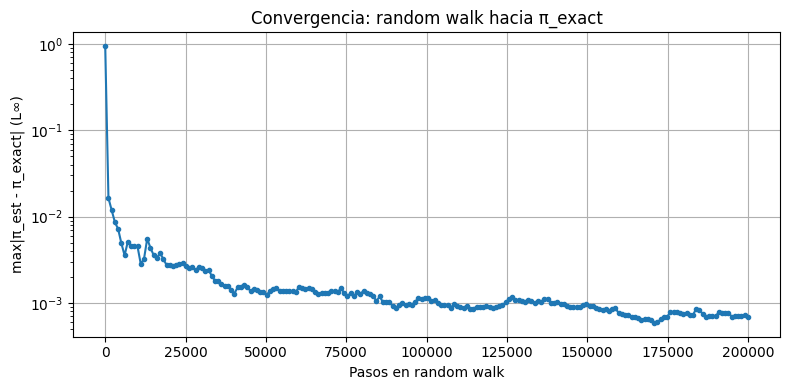

In [56]:
# GRAFICA:Convergencia del random walk (checkpoints)
def pi_random_walk_convergence(P, n_steps=200_000, checkpoints=200, seed=RANDOM_SEED):
    rng = np.random.default_rng(seed)   # para reproducibilidad
    n = P.shape[0]                      # número de estados
    current = 0                         # empieza en estado 0 (casilla 1)
    counts = np.zeros(n, dtype=np.int64)    # contador de visitas
    ks = np.linspace(1, n_steps, checkpoints, dtype=int) # checkpoints
    errors = []                         # errores en checkpoints    
    step = 0                            # pasos realizados

    for k_target in ks:                 # para cada checkpoint
        while step < k_target:          # mientras no llegue a 50, avanza hasta el checkpoint
            counts[current] += 1
            probs = P[current]          # probabilidades de transición
            current = rng.choice(n, p=probs)  # siguiente estado
            step += 1 

        est = counts / counts.sum() # estimación actual de π
        errors.append(np.max(np.abs(est - pi_e)))  # norma infinito respecto a pi_exact
    return ks, errors

ks, errors = pi_random_walk_convergence(P, n_steps=200_000, checkpoints=200)
plt.figure(figsize=(8,4))
plt.plot(ks, errors, marker='.')
plt.yscale('log')
plt.xlabel('Pasos en random walk')
plt.ylabel('max|π_est - π_exact| (L∞)')
plt.title('Convergencia: random walk hacia π_exact')
plt.grid(True)
plt.tight_layout()
plt.show() # gráfico de convergencia

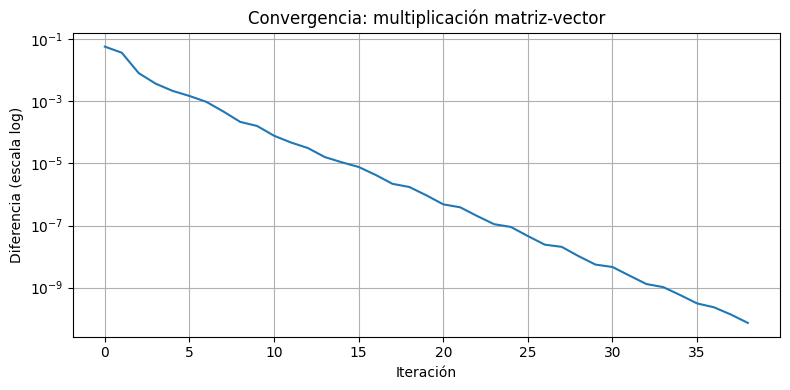

In [57]:
# GRAFICA: convergencia del método iterativo (error por iteración)
plt.figure(figsize=(8,4))
plt.plot(diffs, label='max|π(k+1)-π(k)|')
plt.yscale('log')
plt.xlabel('Iteración')
plt.ylabel('Diferencia (escala log)')
plt.title('Convergencia: multiplicación matriz-vector')
plt.grid(True)
plt.tight_layout()
plt.show()

In [58]:
# SIMULACIÓN DE PARTIDAS: duración esperada y vector de visitas por partida
avg_turns, visitas_por_partida = simulate_games(N_games=20000, verbose=True, seed=RANDOM_SEED)
print('\nDuración media por partida (turnos):', avg_turns)
np.savetxt(os.path.join(out_dir, 'visitas_por_partida.csv'), visitas_por_partida, delimiter=',')
print('Vector visitas por partida guardado en', os.path.join(out_dir, 'visitas_por_partida.csv'))

Simulación de 20000 partidas (esto puede tardar)...
  partidas simuladas: 2000/20000 (10%), duración promedio hasta ahora = 18.6370 turnos
  partidas simuladas: 4000/20000 (20%), duración promedio hasta ahora = 18.5590 turnos
  partidas simuladas: 6000/20000 (30%), duración promedio hasta ahora = 18.5153 turnos
  partidas simuladas: 8000/20000 (40%), duración promedio hasta ahora = 18.5324 turnos
  partidas simuladas: 10000/20000 (50%), duración promedio hasta ahora = 18.5522 turnos
  partidas simuladas: 12000/20000 (60%), duración promedio hasta ahora = 18.5901 turnos
  partidas simuladas: 14000/20000 (70%), duración promedio hasta ahora = 18.6293 turnos
  partidas simuladas: 16000/20000 (80%), duración promedio hasta ahora = 18.6189 turnos
  partidas simuladas: 18000/20000 (90%), duración promedio hasta ahora = 18.6623 turnos
  partidas simuladas: 20000/20000 (100%), duración promedio hasta ahora = 18.6492 turnos
Simulación de partidas finalizada en 0.64 s

Duración media por partida

In [59]:
# %%
# VERIFICACIÓN: normalizar vector visitas por partida y comparar con pi_exact

# Normalizar visitas por partida
visitas_norm = visitas_por_partida / visitas_por_partida.sum()

# Guarda la versión normalizada
pd.DataFrame(visitas_norm, columns=['visitas_norm']).to_csv(os.path.join(out_dir, 'visitas_por_partida_normalizada.csv'), index=False)

# Comparaciones numéricas con pi_exact (ya calculado antes como pi_e)
max_abs_diff = np.max(np.abs(pi_e - visitas_norm))  # máxima diferencia absoluta
rmse = np.sqrt(np.mean((pi_e - visitas_norm)**2))   # raíz del error cuadrático medio
corr = np.corrcoef(pi_e, visitas_norm)[0,1]         # correlación de Pearson

print('\n=== VERIFICACIÓN: visitas_por_partida vs π_exact ===')
print(f'  Máxima diferencia absoluta: {max_abs_diff:.6e}')
print(f'  RMSE: {rmse:.6e}')
print(f'  Correlación (Pearson): {corr:.6f}')

# Muestra las primeras filas comparadas
df_check = pd.DataFrame({
    'pi_exact': pi_e,
    'visitas_norm': visitas_norm,
    'diff': pi_e - visitas_norm
})
print('\nPrimeras 12 entradas de la comparación:')
print(df_check.head(12).to_string(index=True))



=== VERIFICACIÓN: visitas_por_partida vs π_exact ===
  Máxima diferencia absoluta: 8.893914e-04
  RMSE: 2.915779e-04
  Correlación (Pearson): 0.999838

Primeras 12 entradas de la comparación:
    pi_exact  visitas_norm      diff
0   0.054511      0.053621  0.000889
1   0.009085      0.008904  0.000181
2   0.010599      0.010432  0.000167
3   0.012366      0.011968  0.000398
4   0.014427      0.014381  0.000046
5  -0.000000      0.000000 -0.000000
6   0.007746      0.007494  0.000253
7   0.009037      0.008813  0.000225
8   0.009029      0.009204 -0.000175
9   0.032959      0.032379  0.000580
10  0.034968      0.035103 -0.000136
11  0.018429      0.017904  0.000524


In [60]:
# # CÁLCULO ANALÍTICO: construye P_abs (50 como estado absorbente) y calcula el tiempo esperado con matriz fundamental
# P_abs = build_transition_matrix(restart_on_50=False, verbose=False)  # 50 será absorbente ahora
# # Q = submatriz 0..48
# Q = P_abs[:49, :49]             # submatriz de estados transitorios
# I = np.eye(Q.shape[0])          # identidad 49x49
# try:
#     Nmat = np.linalg.inv(I - Q) # matriz fundamental
#     t_vec = Nmat.sum(axis=1)    # vector de tiempos esperados desde cada estado
#     print("Tiempo esperado (analítico) hasta alcanzar casilla 50 empezando en casilla 1:", t_vec[0])
#     print("Duración simulada (avg_turns):", avg_turns)
#     print("Diferencia simulación - analítico:", avg_turns - t_vec[0])
# except np.linalg.LinAlgError as e:
#     print("No se pudo invertir I-Q (singular). Error:", e)

Contando caras del dado en 20000 partidas (esto puede tardar)...
  partidas procesadas: 2000/20000 (10%)
  partidas procesadas: 4000/20000 (20%)
  partidas procesadas: 6000/20000 (30%)
  partidas procesadas: 8000/20000 (40%)
  partidas procesadas: 10000/20000 (50%)
  partidas procesadas: 12000/20000 (60%)
  partidas procesadas: 14000/20000 (70%)
  partidas procesadas: 16000/20000 (80%)
  partidas procesadas: 18000/20000 (90%)
  partidas procesadas: 20000/20000 (100%)
Conteo finalizado en 0.69 s

=== RESULTADO: frecuencia de caras del dado ===
Conteo por cara  (1..6): [68758, 68744, 69037, 68726, 69666, 68817]
Total de lanzamientos registrados: 413748
La cara más frecuente fue: 5  (frecuencia relativa = 0.1684)


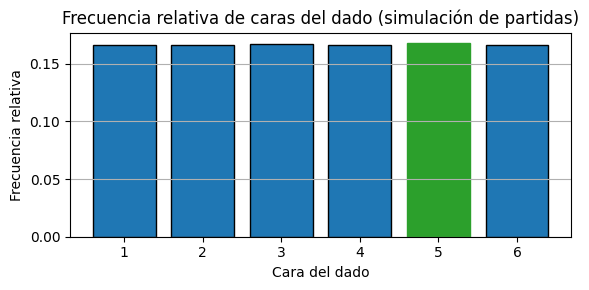

In [61]:
# Este bloque cuenta las caras del dado durante simulaciones de partidas (No se pide en la tarea pero es interesante)

def play_one_game_countdice(rng):
    #Versión de play_one_game que además cuenta las caras del dado
    pos = 0  # index 0 => casilla 1
    turns = 0 # contador de turnos
    visits = np.zeros(N, dtype=np.int64) # cantidad de visitas por casilla
    dice_counts = np.zeros(6, dtype=np.int64)  # índices 0..5 -> caras 1..6
    while True:
        visits[pos] += 1
        turns += 1
        extra = True
        while extra:
            extra = False
            d = int(rng.integers(1, 7))  # lanzamiento 1..6
            dice_counts[d-1] += 1
            if pos + d > 49:                    # si rebasa con 6: se queda en i; pero si es 6, se repite el turno 
                # se pasa: no se mueve
                if d == 6:
                    extra = True
            else: 
                newpos = pos + d                # nuevo destino potencial
                if newpos in jump_idx:          # activa salto
                    dest = jump_idx[newpos]
                    # si llega a 50 -> fin de partida
                    if dest == 49:              # si mi destino es 49, fin de partida
                        return turns, visits, dice_counts
                    pos = dest
                    # si cayó en salto, no repites
                else:
                    if newpos == 49:
                        return turns, visits, dice_counts #repite el turno 
                    pos = newpos
                    if d == 6:
                        extra = True
        # siguiente turno comienza en 'pos'

def simulate_dice_counts_from_games(N_games=20000, verbose=True, seed=RANDOM_SEED):
    rng = np.random.default_rng(seed)
    acc_counts = np.zeros(6, dtype=np.int64) # acumulador de conteos de caras
    t0 = time.time() 
    report_every = max(1, N_games // 10) # reporte cada 10%

    if verbose: 
        print(f'Contando caras del dado en {N_games} partidas (esto puede tardar)...')

    for g in range(N_games):
        _, _, c = play_one_game_countdice(rng) #Ejecuta la simulación de la partida y obtiene el conteo de dados
        acc_counts += c

        if verbose and ((g+1) % report_every == 0): # reporte de progreso
            print(f'  partidas procesadas: {g+1}/{N_games} ({(g+1)/N_games:.0%})') 
    t1 = time.time()

    if verbose: 
        print('Conteo finalizado en', round(t1-t0,2), 's')
    return acc_counts

# Ejecuta el conteo (se puede ajustar N_games si requieres más/menos precisión)
dice_counts = simulate_dice_counts_from_games(N_games=20000, verbose=True, seed=RANDOM_SEED+10)
total_rolls = dice_counts.sum() # total lanzamientos
freq = dice_counts / total_rolls # frecuencia relativa
most_face = np.argmax(dice_counts) + 1  # 1..6

print('\n=== RESULTADO: frecuencia de caras del dado ===')
print('Conteo por cara  (1..6):', dice_counts.tolist()) 
print(f'Total de lanzamientos registrados: {total_rolls}')
print(f'La cara más frecuente fue: {most_face}  (frecuencia relativa = {freq[most_face-1]:.4f})')

# Gráfico sencillo de barras (resalta la cara más frecuente)
plt.figure(figsize=(6,3))
bars = plt.bar(np.arange(1,7), freq, edgecolor='k')
bars[most_face-1].set_color('tab:green')
plt.xlabel('Cara del dado')
plt.ylabel('Frecuencia relativa')
plt.title('Frecuencia relativa de caras del dado (simulación de partidas)')
plt.xticks(np.arange(1,7))
plt.grid(axis='y')
plt.tight_layout()
plt.show()



Generando histograma de duración de partidas (simulación corta de 2000 partidas)...


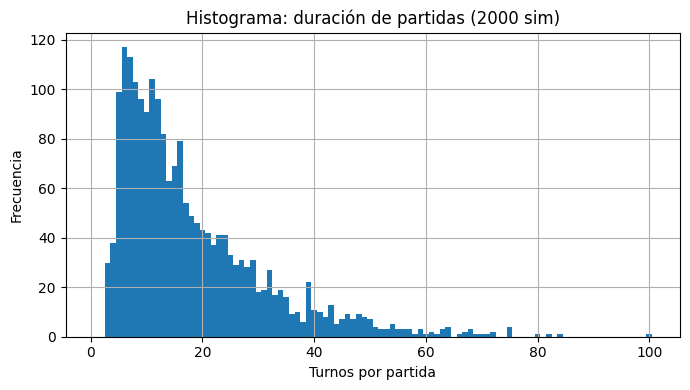

In [62]:
# GRAFICA: histograma aproximado de duraciones (opcional: simular y recolectar duraciones individuales), con menos partidas para rapidez
print('\nGenerando histograma de duración de partidas (simulación corta de 2000 partidas)...')

rng = np.random.default_rng(RANDOM_SEED+1)      # semilla diferente
durations = []                                  # lista de duraciones
for _ in range(2000):                           # simula 2000 partidas
    t, _ = play_one_game(rng)                   # no importa visitas aquí
    durations.append(t)                         # guarda la duración

plt.figure(figsize=(7,4))
plt.hist(durations, bins=range(1, max(durations)+2), align='left')
plt.xlabel('Turnos por partida')
plt.ylabel('Frecuencia')
plt.title('Histograma: duración de partidas (2000 sim)')
plt.grid(True)
plt.tight_layout()
plt.show()

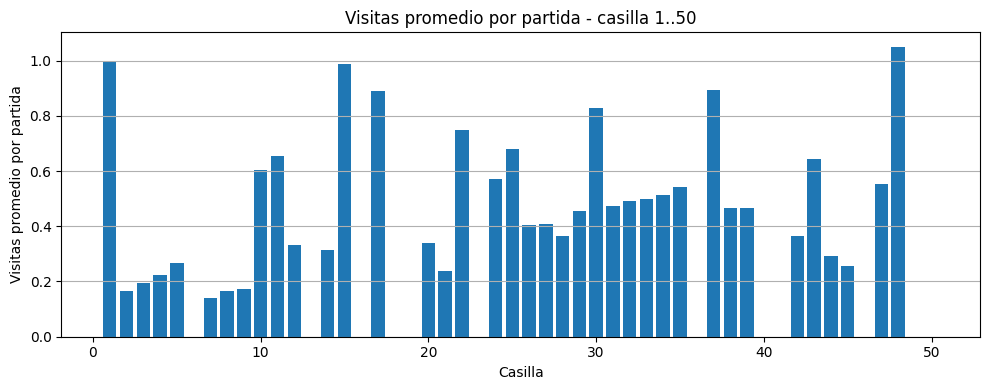

In [63]:
# GRAFICA: visitas por casilla (promedio por partida)
plt.figure(figsize=(10,4))
plt.bar(np.arange(1,N+1), visitas_por_partida)
plt.xlabel('Casilla')
plt.ylabel('Visitas promedio por partida')
plt.title('Visitas promedio por partida - casilla 1..50')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [64]:
# RESUMEN FINAL E IMPRESIÓN DE RESULTADOS IMPORTANTES
print('\n=== RESUMEN DE RESULTADOS ===')
print('Duración media por partida (estimada):', avg_turns)
print('\nTop 10 casillas por π (probabilidad estacionaria):')
order = np.argsort(-pi_e)
for idx in order[:10]:
    print(f'  casilla {idx+1:2d}: π = {pi_e[idx]:.6f}, visitas_por_partida = {visitas_por_partida[idx]:.4f}')

print('\nLos archivos generados están en:', out_dir)
print(' - matriz_transicion.csv')
print(' - pi_vector.csv (exacto)')
print(' - pi_iter.csv (iterativo)')
print(' - pi_vector_simulation.csv (random walk)')
print(' - visitas_por_partida.csv')


=== RESUMEN DE RESULTADOS ===
Duración media por partida (estimada): 18.64925

Top 10 casillas por π (probabilidad estacionaria):
  casilla 48: π = 0.055455, visitas_por_partida = 1.0496
  casilla  1: π = 0.054511, visitas_por_partida = 1.0000
  casilla 15: π = 0.052715, visitas_por_partida = 0.9863
  casilla 37: π = 0.048408, visitas_por_partida = 0.8948
  casilla 17: π = 0.047284, visitas_por_partida = 0.8908
  casilla 30: π = 0.044084, visitas_por_partida = 0.8270
  casilla 22: π = 0.040450, visitas_por_partida = 0.7496
  casilla 25: π = 0.036545, visitas_por_partida = 0.6787
  casilla 11: π = 0.034968, visitas_por_partida = 0.6546
  casilla 43: π = 0.034648, visitas_por_partida = 0.6428

Los archivos generados están en: csv
 - matriz_transicion.csv
 - pi_vector.csv (exacto)
 - pi_iter.csv (iterativo)
 - pi_vector_simulation.csv (random walk)
 - visitas_por_partida.csv


In [65]:
# FIN
print('Notebook completado.')

Notebook completado.
